In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import torch.optim as optim

from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
%matplotlib inline

# from ConsciousLR import ConsciousLR

from IPython import display

class Net(nn.Module):
    def __init__(self, sample_size=1000, model='2x', fill = 1 ):
        super().__init__()
        self.model = model
        self.fc1 = nn.Linear(1, 1, bias=False)
        self.fc1.weight.data.fill_(fill)
    def forward(self, x):
        out = self.fc1(x)
        return out

        

torch.manual_seed(1)
sample_size = 1000
x = torch.randn(sample_size, 1)
y = x*2
y.shape

net1 = Net()
net2 = Net()

class Crit:
    def __init__(self, measure="MSE"):
        self.measure = measure
    def __call__(self, pred, y):
        if self.measure=="MSE":
            return (pred-y).pow(2).mean()
        elif self.measure=="MAE":
            return (pred-y).abs().mean()
        else:
            return ((pred-y).pow(4)-8*(pred-y).pow(2)).mean()

In [2]:
import math
# import torch
from torch.optim.optimizer import Optimizer, required
# import numpy as np
class ConsciousLR(Optimizer):
    r"""Implements AdamW algorithm.

    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, stepSize, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, amsgrad=False, lrHigh=.05, lrLow=.95):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        lrHigh=lrHigh, lrLow=lrLow, stepSize=stepSize)
        super(ConsciousLR, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(ConsciousLR, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue


                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['gai'] = torch.ones_like(p, memory_format=torch.preserve_format)
                    state['cumm'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Accumulate gradients for the epoch
                state['cumm']+=(p.grad)
#                 print('step', state['step'], 'cumm', state['cumm'], 'grad', p.grad.item())


                # Perform stepweight decay
                p.mul_(1 - group['lr'] * state['gai'] * group['weight_decay'])


                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
#                 print('exp_avg',state['exp_avg'])
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
#                 exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['exp_avg'] = beta1 * (exp_avg) + (1-beta1)*(grad)
#                 print('exp_avg',state['exp_avg'])
#                 exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['exp_avg_sq'] = beta2 * exp_avg_sq + (1-beta2)*grad.pow(2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
#                 else:
#                     denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                # Correction
                exp_avgCorr = state['exp_avg']/(1-beta1**state['step'])
#                 print('exp_avgCorr',exp_avgCorr)
                exp_avg_sqCorr = state['exp_avg_sq']/(1-beta2**state['step'])

#                 step_size = group['lr'] / bias_correction1
                step_size = group['lr']
#                 gai = state['gai']
#                 numer = exp_avg.mul(state['gai'])
#                 numer = exp_avg * gai
#                 print(numer, ' equals ', exp_avg, gai, state['gai'])
#                 p.addcdiv_(numer, denom, value=-step_size)
                p -= step_size*state['gai']*(exp_avgCorr/(exp_avg_sqCorr.sqrt()+group['eps']))
                # SetLR if i>0
                if state['step']/group['stepSize'] > 1 and state['step']%group['stepSize']==0:
                    tmp2 = state['gradOld'].clone().cpu()##could be eliminated
                    tmp3 = state['cumm'].clone().cpu()##could be eliminated
                    tmp5 = state['gai'].clone().cpu()##may be the one that needs cloning
#                     print(f'old {tmp2}, cumm {tmp3}')
#                     print(state['step'],' is ', state['gai'].item())
                    state['gai'] = torch.as_tensor(np.where(tmp2*tmp3<=0, tmp5.mul(group['lrLow']), tmp5.add(group['lrHigh'])),dtype=p.dtype , device=p.device)
#                     print(state['step'],' is ', state['gai'].item())

                # Resetting the accumulated gradients after each epoch
                if state['step']%group['stepSize']==0:
                    cumm = state['cumm']
                    state['gradOld'] = cumm.clone()
                    state['cumm'] = torch.zeros_like(p, memory_format=torch.preserve_format)



        return loss


In [173]:
out2 = widgets.Output()
out0 = widgets.Output()
plt.ioff()
plt.close('all');

In [174]:
lossType = widgets.ToggleButtons(
    options=['MSE', 'MAE', 'Saddle'],
    description='Loss Function',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Mean Squared Error Loss', 'Mean Absolute Error Loss', 'A Custom Loss Function with a Saddle'],
    value='Saddle'
#     icons=['check'] * 3
)
measure = lossType.value

outw = widgets.Output()
www = widgets.FloatSlider(min=0, max=4, description="Initial Weight")
ep = widgets.IntText(description="Number of Epochs", value=10)

In [175]:
def train_click(b):
    global weight_space
    global losses
    global crit
    global measure
    global x1data, x2data, y1data, y2data
    global startW
    global ax1,ax2, fig
    net1.fc1.weight.data.fill_(www.get_interact_value()); net2.fc1.weight.data.fill_(www.get_interact_value())
    opt1 = optim.Adam(net1.parameters(),lr=lr)
    opt2 = ConsciousLR(net2.parameters(), 1, lr=lr, lrLow=.5, lrHigh=1.5)
    for _ in range(ep.value):
#         ax1.clear()
#         ax2.clear()
        time.sleep(1)
        w_a = net1.fc1.weight.data.item()
        w_c = net2.fc1.weight.data.item()

    #     time.sleep(1.)
        opt1.zero_grad()
        l1 = crit(net1(x), y)
        l1.backward()
        opt1.step()

        opt2.zero_grad()
        l2 = crit(net2(x), y)
        l2.backward()
        opt2.step()



        x1data.append(w_a)
        x2data.append(w_c)

        y1data.append(l1.item())
        y2data.append(l2.item())

        ax1.plot(x1data, y1data, 'blue', lw=3, alpha=0.4)
        ax2.plot(x2data, y2data, 'black', lw=3, alpha=0.4)
        
        with out2:
            display.clear_output(wait=True)
            display.display(fig)
            

In [176]:
def lossHandler(change):
    global weight_space
    global losses
    global crit
    global measure
    global x1data, x2data, y1data, y2data
    global startW
    global fig, ax1, ax2
#     if change['new']
    out0.clear_output(wait=True)
    out2.clear_output(wait=True)
#     time.sleep(1)

    
    measure = change['new']
    
#     fig, ax = plt.subplots(1,2)
#     for a, loss in zip(ax, losses):
#         a.plot(weight_space ,loss, c='red')
            
    steps = 50
    weight_space = torch.linspace(0, 4, steps=steps)
    crit = Crit(measure=measure)

    loss1 = np.zeros((steps))
    loss2 = np.zeros((steps))
    for i, w in enumerate(weight_space):
        net1.fc1.weight.data.fill_(w)
        net2.fc1.weight.data.fill_(w)
        with torch.no_grad():
            loss1[i] = crit(net1(x), y)
            loss2[i] = crit(net2(x), y)
    losses = [loss1, loss2]
    lr = 1e-2

    out2.clear_output(wait=True)
    opt1 = optim.Adam(net1.parameters(),lr=lr)
    opt2 = ConsciousLR(net2.parameters(), 1, lr=lr, lrLow=.5, lrHigh=1.5)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,4))
    ax1.plot(weight_space ,losses[0], c='red')
    ax2.plot(weight_space ,losses[0], c='red')

    ax1.set_title('Adam')
    ax2.set_title("ActiveLR")
    
    # ax1, ax2 = ax
    x1data, x2data, y1data, y2data = [], [], [], []
    # ln1, = ax1.plot([], [], 'blue', lw=3, alpha=0.4)
    # ln2, = ax2.plot([], [], 'black', lw=3, alpha=0.4)
    # line = [ln1, ln2]

    ax1.set_xlim(torch.min(weight_space).item(), torch.max(weight_space).item())
    ax1.set_ylim((losses[0]).min(), (losses[0]).max())

    ax2.set_xlim(torch.min(weight_space).item(), torch.max(weight_space).item())
    ax2.set_ylim((losses[0]).min(), (losses[0]).max())


    button = widgets.Button(description='Train')
    button.on_click(train_click)


    out2.clear_output(wait=True)
    with out0:
        display.display(lossType, button,)
    with out2:
        display.display(fig)

lossType.observe(lossHandler, names='value')

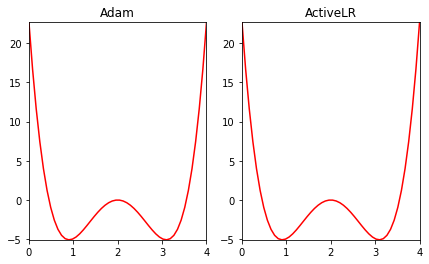

In [177]:


# measure='MSE'
steps = 50
weight_space = torch.linspace(0, 4, steps=steps)
crit = Crit(measure=measure)

pause=False

loss1 = np.zeros((steps))
loss2 = np.zeros((steps))
for i, w in enumerate(weight_space):
    net1.fc1.weight.data.fill_(w)
    net2.fc1.weight.data.fill_(w)
    with torch.no_grad():
        loss1[i] = crit(net1(x), y)
        loss2[i] = crit(net2(x), y)
losses = [loss1, loss2]
lr = 1e-2

out2.clear_output(wait=True)
opt1 = optim.Adam(net1.parameters(),lr=lr)
opt2 = ConsciousLR(net2.parameters(), 1, lr=lr, lrLow=.5, lrHigh=1.5)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,4))
ax1.plot(weight_space ,losses[0], c='red')
ax2.plot(weight_space ,losses[0], c='red')

ax1.set_title('Adam')
ax2.set_title("ActiveLR")

x1data, x2data, y1data, y2data = [], [], [], []

ax1.set_xlim(torch.min(weight_space).item(), torch.max(weight_space).item())
ax1.set_ylim((losses[0]).min(), (losses[0]).max())

ax2.set_xlim(torch.min(weight_space).item(), torch.max(weight_space).item())
ax2.set_ylim((losses[0]).min(), (losses[0]).max())


   
button = widgets.Button(description='Train')
button.on_click(train_click)


out2.clear_output(wait=True)
with out0:
    display.display(lossType, button)
with out2:
    display.display(fig)
    
# plt.show()

In [178]:
def weightHandler(change):
    global startW
    startW=change['new']

In [179]:
www.observe(weightHandler, names='value')

In [180]:
outw.clear_output(wait=True)
with outw:
    display.display(www, ep)

In [181]:
outw

Output()

In [182]:
out0

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "ToggleButtons(description='Loss Functi…

In [183]:
out2

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 504x288 with 2 Axes>', 'i…